In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def Initialize(particlePerCell_1D, nodeNum_1D, domainBegin, domainEnd, dt, simulationTime, randomParticle):
    if randomParticle:
        pass
    else:
        particleNum_1D = (nodeNum_1D - 1) * (particlePerCell_1D - 1) + 1  # Number of particles in 'x' or 'y' dimension
        domainLength = domainEnd - domainBegin
        dx = domainLength * 1.1 / (nodeNum_1D - 1) # Node spacing 1D
        dp = domainLength / (particleNum_1D - 1) # particle spacing 1D

        nodeNum = nodeNum_1D**2
        xI = np.zeros((nodeNum,2))
        Node_idx = 0
        for nodeX in range(nodeNum_1D):
            for nodeY in range(nodeNum_1D):
                xI[Node_idx,:] = [domainBegin - 0.05*domainLength + dx*nodeX ,domainBegin - 0.05 * domainLength + dx*nodeY]
                Node_idx += 1

        particleNum = particleNum_1D**2
        xp = np.zeros((particleNum,2))
        particle_idx = 0
        for particleX in range(particleNum_1D):
            for particleY in range(particleNum_1D):
                xp[particle_idx,:] = [domainBegin + dp*particleX,domainBegin + dp*particleY]
                particle_idx += 1

        uI = np.zeros(nodeNum)
        timeStepNum = int(simulationTime / dt)

        vp = np.zeros(particleNum)
        vp_unit = 1 / ( 4*(particleNum_1D - 2)**2 + 2*((particleNum_1D - 2)*4) + 4)
        n = np.zeros((particleNum,2))
        for i in range(particleNum):
            if xp[i,0] == -1 and xp[i,1] == -1:
                vp[i] = vp_unit
                n[i,:] = [-1,-1]
            elif xp[i,0] == 1 and xp[i,1] == -1:
                vp[i] = vp_unit
                n[i,:] = [1,-1]
            elif xp[i,0] == -1 and xp[i,1] == 1:
                vp[i] = vp_unit
                n[i,:] = [-1,1]
            elif xp[i,0] == 1 and xp[i,1] == 1:
                vp[i] = vp_unit
                n[i,:] = [1,1]
            elif xp[i,0] == -1:
                vp[i] = vp_unit * 2
                n[i,:] = [-1,0]
            elif xp[i,0] == 1:
                vp[i] = vp_unit * 2
                n[i,:] = [1,0]
            elif xp[i,1] == -1:
                vp[i] = vp_unit * 2
                n[i,:] = [0,-1]
            elif xp[i,1] == 1:
                vp[i] = vp_unit * 2
                n[i,:] = [0,1]
            else:
                vp[i] = vp_unit * 4
                n[i,:] = [0,0]

    return particleNum, dx, dp, xp, xI, uI, timeStepNum, vp, n

In [3]:
def GetRK(xI, dx, xp, supportNorm): # Node location, Node spacing, Particle location, Normalized RK approximation support size
    nodeNum = len(xI)                   # Number of background grid nodes
    particleNum = len(xp)               # Number of locations to evaluate the RK shape functions at
    w = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    phi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape functions
    dphi_X = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape function gradient
    dphi_Y = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum):
        M = np.zeros((3, 3))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = np.linalg.norm(xp[idx,:] - xI[I,:]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            PxI = np.array([1, xI[I,0] - xp[idx,0], xI[I,1] - xp[idx,1]])  # Define P(xI - xp)
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J,0] - xp[idx,0], xI[J,1] - xp[idx,1]])
            Ploc = np.array([1, 0, 0])
            PlocGrad_X = np.array([0, 1, 0])
            PlocGrad_Y = np.array([0, 0, 1])
            phi[J, idx] = w[J, idx] * np.dot(Ploc, np.linalg.solve(M, PxI))
            dphi_X[J, idx] = w[J, idx] * np.dot(PlocGrad_X, np.linalg.solve(M, PxI))
            dphi_Y[J, idx] = w[J, idx] * np.dot(PlocGrad_Y, np.linalg.solve(M, PxI))

    return phi, dphi_X, dphi_Y

In [4]:
def get_vc(phi, dphi_X, dphi_Y, nodeNum, vp, n):
    eps = 1e-15
    ksiNum_X = np.zeros(nodeNum)
    ksiDen = np.zeros(nodeNum)
    ksiNum_Y = np.zeros(nodeNum)

    for I in range(nodeNum):
        ksiNum_X[I] = np.dot(dphi_X[I, :], vp)
        ksiNum_X[I] -= np.dot(phi[I, :], n[:, 0]) * 1
        ksiNum_Y[I] = np.dot(dphi_Y[I, :], vp)
        ksiNum_Y[I] -= np.dot(phi[I, :], n[:, 1]) * 1
        localParticle = np.abs(phi[I, :]) > eps
        ksiDen[I] = np.sum(vp[localParticle])

    ksi_X = -ksiNum_X / ksiDen
    ksi_Y = -ksiNum_Y / ksiDen

    return ksi_X, ksi_Y, eps

In [20]:
def get_NSNI(xI,dx,xp,supportNorm,dp,nodeNum,particleNum):
    XP = np.zeros((particleNum*4,2)) # 左右下上
    for p in range(particleNum):
        XP[p*4+0,:] += (xp[p,0] - dp/2,xp[p,1])
        XP[p*4+1,:] += (xp[p,0] + dp/2,xp[p,1])
        XP[p*4+2,:] += (xp[p,0],xp[p,1] - dp/2)
        XP[p*4+3,:] += (xp[p,0],xp[p,1] + dp/2)

    # print(XP)
    particleNum_plus = len(XP)
    MoI1 = np.zeros(particleNum)
    MoI2 = np.zeros(particleNum)

    # define RK on conforming boundary
    w = np.zeros((nodeNum, particleNum_plus))  # Initialize vector for kernel function weights
    phi = np.zeros((nodeNum, particleNum_plus))  # Initialize vector for RK shape functions
    dphi_X = np.zeros((nodeNum, particleNum_plus))  # Initialize vector for RK shape function gradient
    dphi_Y = np.zeros((nodeNum, particleNum_plus))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization

    for idx in range(particleNum_plus):
        M = np.zeros((3, 3))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = np.linalg.norm(XP[idx,:] - xI[I,:]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0 + 1e-12

            PxI = np.array([1, xI[I,0] - XP[idx,0], xI[I,1] - XP[idx,1]])  # Define P(xI - xp)
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J,0] - XP[idx,0], xI[J,1] - XP[idx,1]])
            Ploc = np.array([1, 0, 0])
            PlocGrad_X = np.array([0, 1, 0])
            PlocGrad_Y = np.array([0, 0, 1])
            phi[J, idx] = w[J, idx] * np.dot(Ploc, np.linalg.solve(M, PxI))
            dphi_X[J, idx] = w[J, idx] * np.dot(PlocGrad_X, np.linalg.solve(M, PxI))
            dphi_Y[J, idx] = w[J, idx] * np.dot(PlocGrad_Y, np.linalg.solve(M, PxI))

    ddphi_X = np.zeros((nodeNum,particleNum))
    ddphi_Y = np.zeros((nodeNum,particleNum))

    for p in range(particleNum):
        # ddphi_X[:,p] = dphi_X[:,p*4+0] * -1 / dp + dphi_X[:,p*4+1] * 1 / dp
        # ddphi_Y[:,p] = dphi_Y[:,p*4+2] * -1 / dp + dphi_Y[:,p*4+3] * 1 / dp
        if xp[p,0] == -1 and xp[p,1] == -1:
            ddphi_X[:,p] = dphi_X[:,p*4+1] * 1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+3] * 1 / dp
            MoI1[p] = dp**4 / 192 + dp**4 / 64
            MoI2[p] = dp**4 / 192 + dp**4 / 64
        elif xp[p,0] == 1 and xp[p,1] == -1:
            ddphi_X[:,p] = dphi_X[:,p*4+0] * -1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+3] * 1 / dp
            MoI1[p] = dp**4 / 192 + dp**4 / 64
            MoI2[p] = dp**4 / 192 + dp**4 / 64
        elif xp[p,0] == -1 and xp[p,1] == 1:
            ddphi_X[:,p] = dphi_X[:,p*4+1] * 1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+2] * -1 / dp
            MoI1[p] = dp**4 / 192 + dp**4 / 64
            MoI2[p] = dp**4 / 192 + dp**4 / 64
        elif xp[p,0] == 1 and xp[p,1] == 1:
            ddphi_X[:,p] = dphi_X[:,p*4+0] * -1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+2] * -1 / dp
            MoI1[p] = dp**4 / 192 + dp**4 / 64
            MoI2[p] = dp**4 / 192 + dp**4 / 64
        elif xp[p,0] == -1:
            ddphi_X[:,p] = dphi_X[:,p*4+1] * 1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+2] * -1 / dp + dphi_Y[:,p*4+3] * 1 / dp
            MoI1[p] = dp**4 / 96 + dp**4 / 32
            MoI2[p] = dp**4 / 24
        elif xp[p,0] == 1:
            ddphi_X[:,p] = dphi_X[:,p*4+0] * -1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+2] * -1 / dp + dphi_Y[:,p*4+3] * 1 / dp
            MoI1[p] = dp**4 / 96 + dp**4 / 32
            MoI2[p] = dp**4 / 24
        elif xp[p,1] == -1:
            ddphi_X[:,p] = dphi_X[:,p*4+0] * -1 / dp + dphi_X[:,p*4+1] * 1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+3] * 1 / dp
            MoI1[p] = dp**4 / 24
            MoI2[p] = dp**4 / 96 + dp**4 / 32
        elif xp[p,1] == 1:
            ddphi_X[:,p] = dphi_X[:,p*4+0] * -1 / dp + dphi_X[:,p*4+1] * 1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+2] * -1 / dp
            MoI1[p] = dp**4 / 24
            MoI2[p] = dp**4 / 96 + dp**4 / 32
        else:
            ddphi_X[:,p] = dphi_X[:,p*4+0] * -1 / dp + dphi_X[:,p*4+1] * 1 / dp
            ddphi_Y[:,p] = dphi_Y[:,p*4+2] * -1 / dp + dphi_Y[:,p*4+3] * 1 / dp
            MoI1[p] = dp**4 / 12
            MoI2[p] = dp**4 / 12

    return ddphi_X,ddphi_Y,MoI1,MoI2

0.010342973419730655


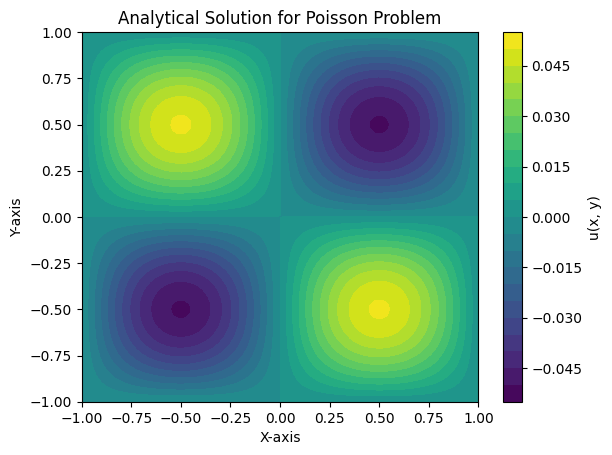

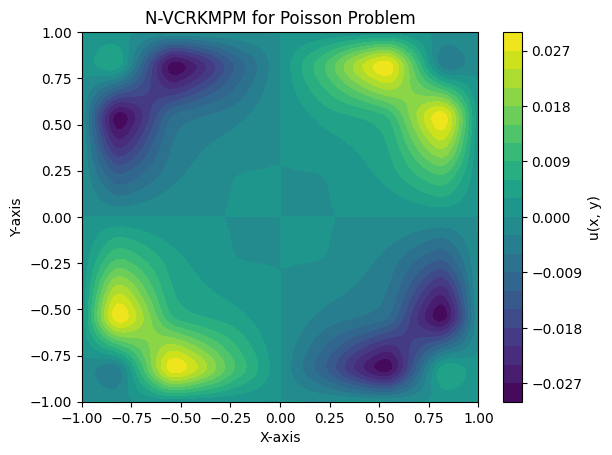

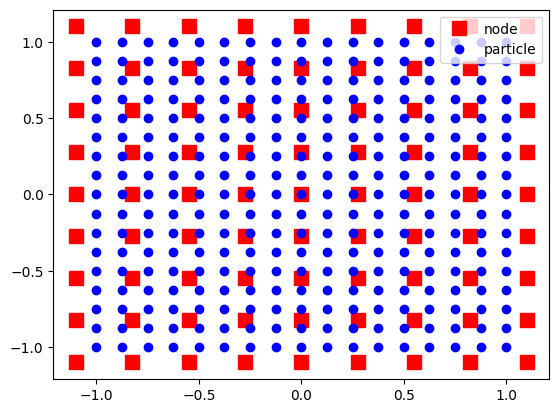

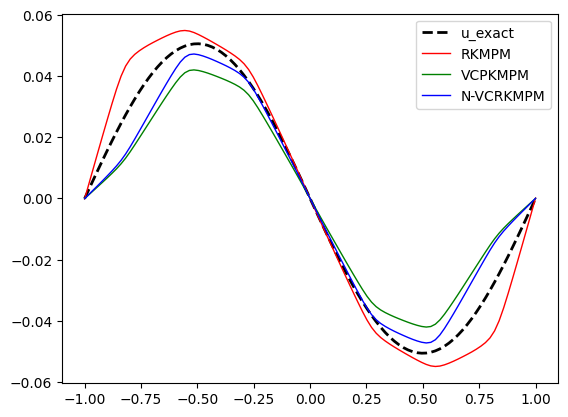

In [45]:
## double gradient(u) = sin(pi*x)sin(pi*y)
## u = 0
## exactsol ==> u = -1 / 2pi^2 * sin(pi*x)sin(pi*y)

randomParticle = False
particlePerCell_1D = 3
domainBegin = -1
domainEnd = 1
simulationTime = 1
dt = 1
betaNorm = 1000
supportNorm = 1.5
dirichletBC1 = -1
dirichletBC2 = 1
VC = True
NSNI = True

# 進行初始化及其他設置
nodeNum_1D = 9
nodeNum = (nodeNum_1D)**2
particleNum, dx, dp, xp, xI, uI, timeStepNum, vp, n = Initialize(particlePerCell_1D, nodeNum_1D, domainBegin, domainEnd, dt, simulationTime, randomParticle)
uI_VC = np.copy(uI)
uI_NSNI = np.copy(uI)

for t in range(timeStepNum):
    K = np.zeros((nodeNum,nodeNum))
    F = np.zeros(nodeNum)
    K_VC = np.zeros((nodeNum,nodeNum))
    K_NSNI = np.zeros((nodeNum,nodeNum))
    beta = betaNorm * 1 / dx

    phi,dphi_X,dphi_Y = GetRK(xI,dx,xp,supportNorm)

    if NSNI:
        ddphi_X,ddphi_Y,MoI1,MoI2 = get_NSNI(xI,dx,xp,supportNorm,dp,nodeNum,particleNum)
        # print(ddphi_X)

    if VC:
        ksi_X, ksi_Y, eps = get_vc(phi, dphi_X, dphi_Y, nodeNum, vp, n) # VC-DNI
        # phi_vc,dphiX_vc,dphiY_vc = GetRK(xI,dx,xp,supportNorm) # create new DNI shape function
        checkVC = 0
        dphi_X_VC = np.copy(dphi_X)
        dphi_Y_VC = np.copy(dphi_Y)

    for p in range(particleNum):
        if VC:
            withinSupport = phi[:, p] > eps # bool
            dphi_X_VC[:, p] = dphi_X_VC[:, p] + ksi_X * withinSupport
            dphi_Y_VC[:, p] = dphi_Y_VC[:, p] + ksi_Y * withinSupport
            checkVC = checkVC + np.dot(dphi_X[:, p], vp[p]) - np.dot(phi[:, p], n[p,0]) * 1
            checkVC = checkVC + np.dot(dphi_Y[:, p], vp[p]) - np.dot(phi[:, p], n[p,1]) * 1
            K_VC -= np.outer(dphi_X_VC[:,p],dphi_X[:,p]) * vp[p]
            K_VC -= np.outer(dphi_Y_VC[:,p],dphi_Y[:,p]) * vp[p]
            K_NSNI -= np.outer(dphi_X_VC[:,p],dphi_X[:,p]) * vp[p]
            K_NSNI -= np.outer(dphi_Y_VC[:,p],dphi_Y[:,p]) * vp[p]

        K -= np.outer(dphi_X[:,p],dphi_X[:,p]) * vp[p]
        K -= np.outer(dphi_Y[:,p],dphi_Y[:,p]) * vp[p]

        if NSNI:
            K_NSNI += np.outer(ddphi_X[:,p],ddphi_X[:,p]) * MoI1[p]
            K_NSNI += np.outer(ddphi_Y[:,p],ddphi_Y[:,p]) * MoI2[p]

        F += phi[:,p] * vp[p] * np.sin(np.pi*xp[p,0]) * np.sin(np.pi*xp[p,1])
        if xp[p,0] == dirichletBC1:
            Nistche_term = beta * np.outer(phi[:,p],phi[:,p]) - np.outer(dphi_X[:,p],phi[:,p]) * n[p,0] * 1 - np.outer(phi[:,p],dphi_X[:,p]) * n[p,0] * 1
            K += Nistche_term
            K_VC += Nistche_term
            K_NSNI += Nistche_term
        elif xp[p,0] == dirichletBC2:
            Nistche_term = beta * np.outer(phi[:,p],phi[:,p]) - np.outer(dphi_X[:,p],phi[:,p]) * n[p,0] * 1 - np.outer(phi[:,p],dphi_X[:,p]) * n[p,0] * 1
            K += Nistche_term
            K_VC += Nistche_term
            K_NSNI += Nistche_term
        elif xp[p,1] == dirichletBC1:
            Nistche_term = beta * np.outer(phi[:,p],phi[:,p]) - np.outer(dphi_Y[:,p],phi[:,p]) * n[p,1] * 1 - np.outer(phi[:,p],dphi_Y[:,p]) * n[p,1] * 1
            K += Nistche_term
            K_VC += Nistche_term
            K_NSNI += Nistche_term
        elif xp[p,1] == dirichletBC2:
            Nistche_term = beta * np.outer(phi[:,p],phi[:,p]) - np.outer(dphi_Y[:,p],phi[:,p]) * n[p,1] * 1 - np.outer(phi[:,p],dphi_Y[:,p]) * n[p,1] * 1
            K += Nistche_term
            K_VC += Nistche_term
            K_NSNI += Nistche_term

    uI = np.linalg.solve(K,F)
    uI_VC = np.linalg.solve(K_VC,F)
    uI_NSNI = np.linalg.solve(K_NSNI,F)

# defined exact solution
num = 100
x = np.linspace(-1, 1, num)
y = np.linspace(-1, 1, num)
X, Y = np.meshgrid(x, y)
u_exact =  (1 / (-2 * np.pi**2)) * np.sin(np.pi * X) * np.sin(np.pi * Y)

xp_x = X.reshape(num**2)
xp_y = Y.reshape(num**2)
XP = np.zeros((num**2,2))
XP[:,0] += xp_x
XP[:,1] += xp_y
phiU,_,_ = GetRK(xI,dx,XP,supportNorm)
uc = np.dot(uI,phiU)
uc_VC = np.dot(uI_VC,phiU)
uc_NSNI = np.dot(uI_NSNI,phiU)
UC = uc.reshape(num,num)
UC_VC = uc_VC.reshape(num,num)
UC_NSNI = uc_NSNI.reshape(num,num)

error = u_exact - UC
L2_error = np.linalg.norm(error)
L2_error = np.sqrt(np.trapz(np.trapz(error**2,x),y))
print(L2_error)

plt.figure(1)
# 繪製等高線圖
plt.contourf(X, Y, u_exact, cmap='viridis', levels=20)
plt.colorbar(label='u(x, y)')
plt.title('Analytical Solution for Poisson Problem')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.figure(2)
plt.contourf(X, Y, UC_NSNI-UC , cmap='viridis', levels=20)
plt.colorbar(label='u(x, y)')
plt.title('N-VCRKMPM for Poisson Problem')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.figure(3)
plt.plot(xI[:,0],xI[:,1],'rs',markersize=10,label='node')
plt.plot(xp[:,0],xp[:,1],'bo',label='particle')
plt.legend()

plt.figure(4)
plt.plot(Y[:,75],u_exact[:,75],'k--',lw=2,label='u_exact')
plt.plot(Y[:,75],UC[:,75],'r',lw=1,label='RKMPM')
plt.plot(Y[:,75],UC_VC[:,75],'g',lw=1,label='VCPKMPM')
plt.plot(Y[:,75],UC_NSNI[:,75],'b',lw=1,label='N-VCRKMPM')
plt.legend()
plt.plot()

plt.show()